In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

# with h5py.File(f'data_large/Burgers_train_100000_default.h5', 'r') as f:
#     # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
#     traj = torch.tensor(f['train']['pde_140-256'][:1000, :131], dtype=torch.float32)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
import hydra
from omegaconf import DictConfig, OmegaConf
from generate_data import evolve
from tqdm import tqdm

hydra.initialize(config_path="cfg_flexible", version_base=None)
cfg = hydra.compose(config_name="config", overrides=["task=NS", "nt=14"])

In [3]:
with h5py.File(cfg.dataset.train_path, 'r') as f:
    # Traj_dataset.traj_train = torch.tensor(f['train']['pde_140-256'][:10000, :131], dtype=torch.float32, device=cfg.device)
    traj = torch.tensor(f['train']['pde'][:1000, :131:10], dtype=torch.float32)
    # traj = torch.tensor(f['train']['pde'][:128, 30:131:5], dtype=torch.float32)

In [4]:
print(traj.shape)

torch.Size([1000, 14, 1, 32, 32])


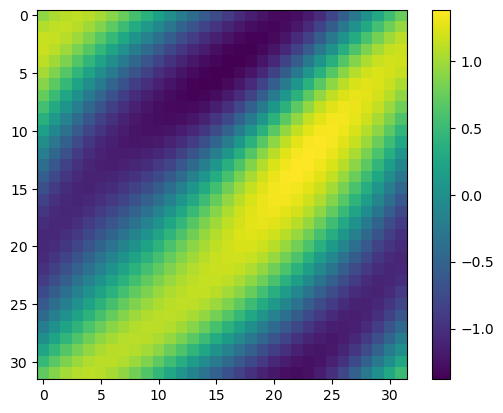

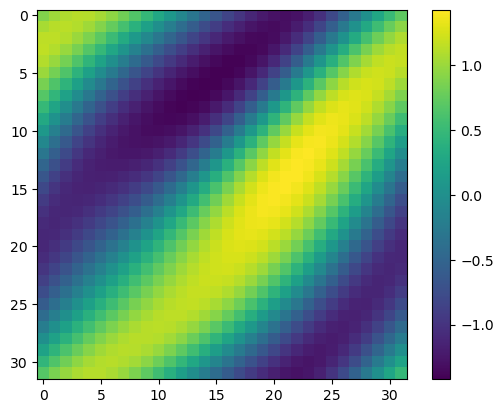

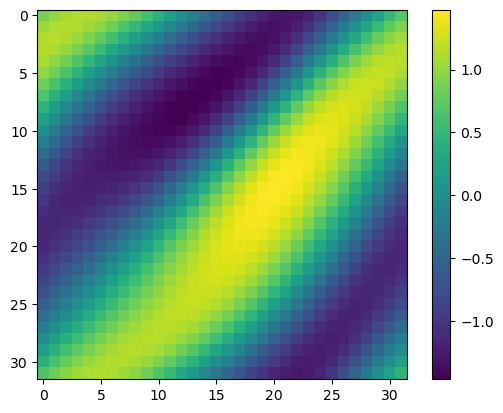

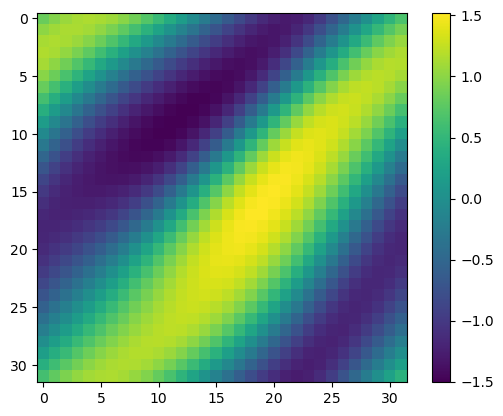

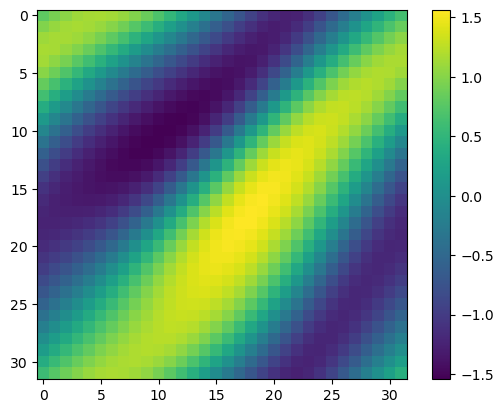

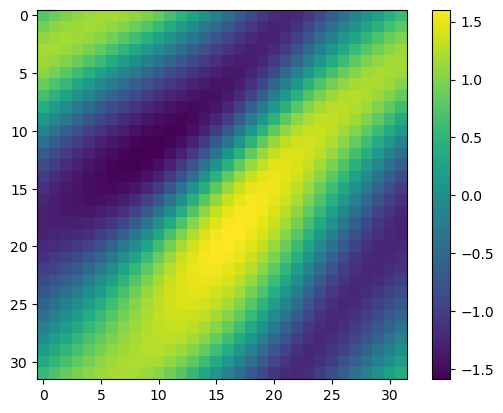

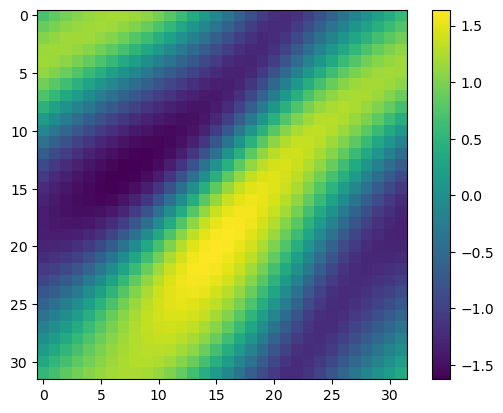

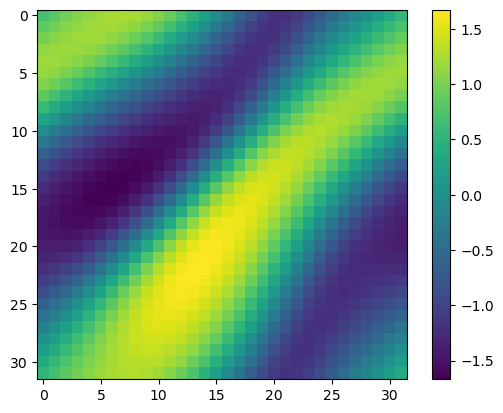

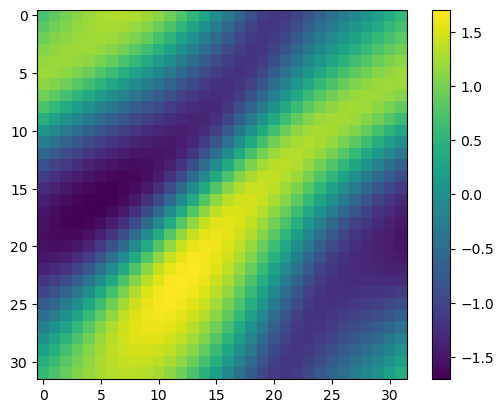

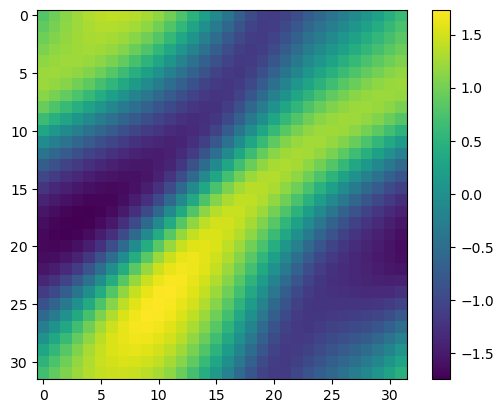

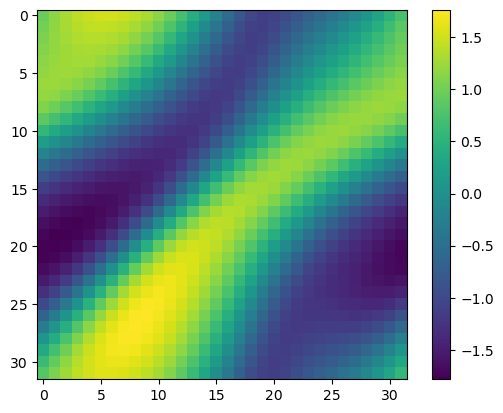

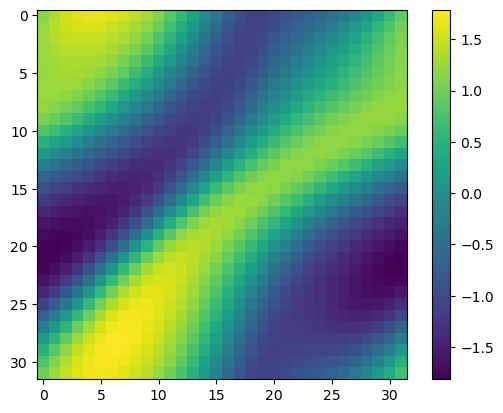

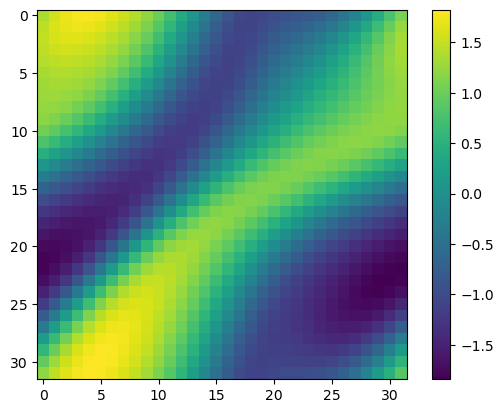

In [5]:
for i in range(13):
    plt.figure()
    plt.imshow(traj[30,i,0].cpu().numpy())
    plt.colorbar()

torch.Size([14000, 1024])
(14000, 2)


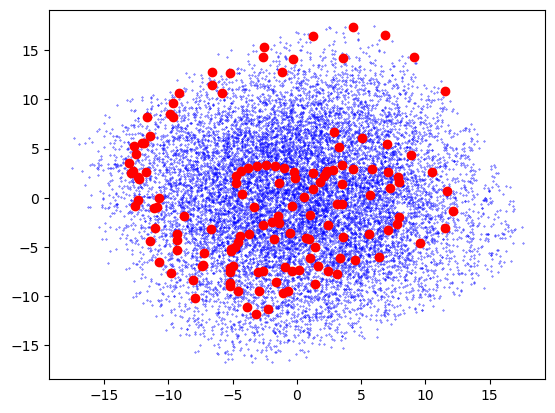

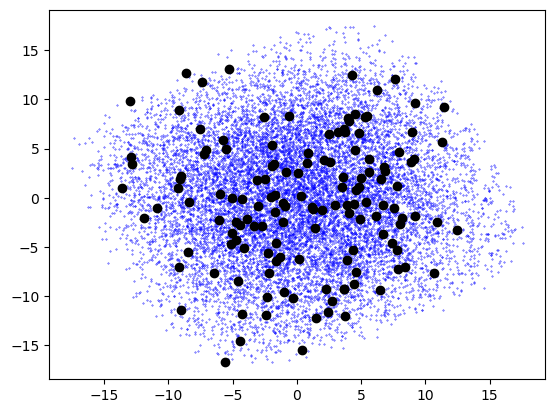

In [6]:
data = traj.flatten(2) # (1000, 131, 1) -> (1000, 131)

selected = torch.zeros(*data.shape[0:2]).bool()
selected[:10, :] = True

selected_scattered = torch.zeros(*data.shape[0:2]).bool()
selected_scattered = selected_scattered.flatten()
selected_scattered[torch.randperm(selected_scattered.shape[0])[:selected.sum()]] = True

data = data.flatten(0,1) # (datasize*nt, nx)
selected = selected.flatten(0,1) # (datasize*nt)

# perform PCA on data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
print(data.shape)
data_transformed = pca.fit_transform(data)
print(data_transformed.shape)

# plot the first two principal components
# plot selected components in red
# plot selected_scattered components in green
# make the points small
plt.figure()
plt.scatter(data_transformed[:,0], data_transformed[:,1], c='b', s=0.1)
plt.scatter(data_transformed[selected,0], data_transformed[selected,1], c='r')

plt.figure()
plt.scatter(data_transformed[:,0], data_transformed[:,1], c='b', s=0.1)
plt.scatter(data_transformed[selected_scattered,0], data_transformed[selected_scattered,1], c='k')

